In [37]:
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

In [38]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [39]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001
SEQ_LENGTH = 24
DATA = './data/meteo_16.9_51.103333_2025-11-30_2022-11-13.csv' 

TARGET_FET = 'apparent_temperature'
DROP_FEATURES = ['date']

MODEL_NAME = 'model_v2_LSTM'
SAVE_PATH = './models'

In [40]:
df = pd.read_csv(DATA)
df['date'] = pd.to_datetime(df['date'])

print(tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+------------------------+--------------------------+----------------+-----------+--------+----------------+------------+--------------+---------------+
|    | date                      |   temperature_2m |   relative_humidity_2m |   apparent_temperature |   surface_pressure |   wind_direction_10m |   wind_speed_10m |   soil_temperature_0cm |   soil_moisture_0_to_1cm |   pressure_msl |   showers |   rain |   dew_point_2m |   snowfall |   snow_depth |   cloud_cover |
|----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+------------------------+--------------------------+----------------+-----------+--------+----------------+------------+--------------+---------------|
|  0 | 2022-11-13 14:00:00+00:00 |           8

In [41]:
df_len = len(df)

train_end = int(df_len * (1 - TEST_SIZE - VAL_SIZE))
val_end = int(df_len * (1 - TEST_SIZE))

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

print(f'Train size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

Train size: 16032
Validation size: 5344
Test size: 5345


In [42]:
def split_Xy(dataset):
    X = dataset.drop(columns=DROP_FEATURES + [TARGET_FET])
    y = dataset[TARGET_FET]
    return X, y

X_train, y_train = split_Xy(train_df)
X_val, y_val = split_Xy(val_df)
X_test, y_test = split_Xy(test_df)


scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaler_X.fit(X_train)
scaler_y.fit(y_train.values.reshape(-1, 1))

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print(pd.DataFrame(X_train_scaled).describe())
print(pd.DataFrame(y_train_scaled).describe())

                 0             1             2             3             4   \
count  1.603200e+04  1.603200e+04  1.603200e+04  1.603200e+04  1.603200e+04   
mean  -3.403798e-16 -2.694673e-16  1.045249e-14 -1.010502e-16  7.800369e-17   
std    1.000031e+00  1.000031e+00  1.000031e+00  1.000031e+00  1.000031e+00   
min   -2.987726e+00 -3.344181e+00 -3.610578e+00 -2.205717e+00 -1.765146e+00   
25%   -7.859165e-01 -6.086021e-01 -5.982553e-01 -7.978515e-01 -7.477887e-01   
50%   -4.711302e-02  2.424667e-01  5.088956e-02  1.525474e-01 -1.575874e-01   
75%    7.792956e-01  7.895824e-01  6.254756e-01  8.713643e-01  5.492384e-01   
max    2.765012e+00  1.519070e+00  3.276681e+00  1.795179e+00  5.357747e+00   

                 5             6             7             8             9   \
count  1.603200e+04  1.603200e+04  1.603200e+04  1.603200e+04  1.603200e+04   
mean  -1.701899e-16 -5.956646e-16  1.162964e-14  1.772811e-18  3.722904e-17   
std    1.000031e+00  1.000031e+00  1.000031e+00  1.

In [43]:
def create_seq(scaled_X, scaled_y, seq_length):
    sequences = []
    targets = []
    
    for i in tqdm(range(len(scaled_X) - seq_length)):
        seq_X = scaled_X[i:i+seq_length]
        seq_y = scaled_y[i+seq_length]
        sequences.append(seq_X)
        targets.append(seq_y)
    return np.array(sequences), np.array(targets)

X_train_seq, y_train_seq = create_seq(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_val_seq, y_val_seq = create_seq(X_val_scaled, y_val_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_seq(X_test_scaled, y_test_scaled, SEQ_LENGTH)

print(f'Train sequences: {X_train_seq.shape}, Train targets: {y_train_seq.shape}')
print(f'Validation sequences: {X_val_seq.shape}, Validation targets: {y_val_seq.shape}')
print(f'Test sequences: {X_test_seq.shape}, Test targets: {y_test_seq.shape}')

  0%|          | 0/16008 [00:00<?, ?it/s]

100%|██████████| 5321/5321 [00:00<00:00, 721118.34it/s]

Train sequences: (16008, 24, 14), Train targets: (16008,)
Validation sequences: (5320, 24, 14), Validation targets: (5320,)
Test sequences: (5321, 24, 14), Test targets: (5321,)


In [44]:
model = tf.keras.Sequential(name=MODEL_NAME)
model.add(tf.keras.layers.InputLayer(shape=(SEQ_LENGTH, X_train_seq.shape[2])))
model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='tanh'))
model.add(tf.keras.layers.LSTM(32, activation='tanh'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])

print(model.summary())

Model: "model_v2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,729 (131.75 KB)

 Trainable params: 33,729 (131.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
monitors = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.10, patience=3, min_lr=1e-6, verbose=1)
]
history = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=monitors)

Epoch 1/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.0554 - mae: 0.1591 - val_loss: 0.0166 - val_mae: 0.0938 - learning_rate: 0.0010
Epoch 2/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0110 - mae: 0.0789 - val_loss: 0.0109 - val_mae: 0.0761 - learning_rate: 0.0010
Epoch 3/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0073 - mae: 0.0631 - val_loss: 0.0064 - val_mae: 0.0567 - learning_rate: 0.0010
Epoch 4/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0061 - mae: 0.0572 - val_loss: 0.0060 - val_mae: 0.0562 - learning_rate: 0.0010
Epoch 5/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0057 - mae: 0.0549 - val_loss: 0.0061 - val_mae: 0.0567 - learning_rate: 0.0010
Epoch 6/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0054 - mae: 0.0536 - val_loss: 0.0059 - val_mae: 0.0564 - learning_rate: 0.0010
Epoch 7/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0053 - mae: 0.0528 - val_loss: 0.0061 - val_mae: 0.0583 - learnin

In [46]:
os.makedirs(os.path.join(SAVE_PATH, MODEL_NAME), exist_ok=True)
model.save(os.path.join(SAVE_PATH, MODEL_NAME, 'model.keras'))
joblib.dump(scaler_X, os.path.join(SAVE_PATH, MODEL_NAME, 'scaler_X.pkl'))
joblib.dump(scaler_y, os.path.join(SAVE_PATH, MODEL_NAME, 'scaler_y.pkl'))

['./models/model_v2_LSTM/scaler_y.pkl']

=== TRAINING ===


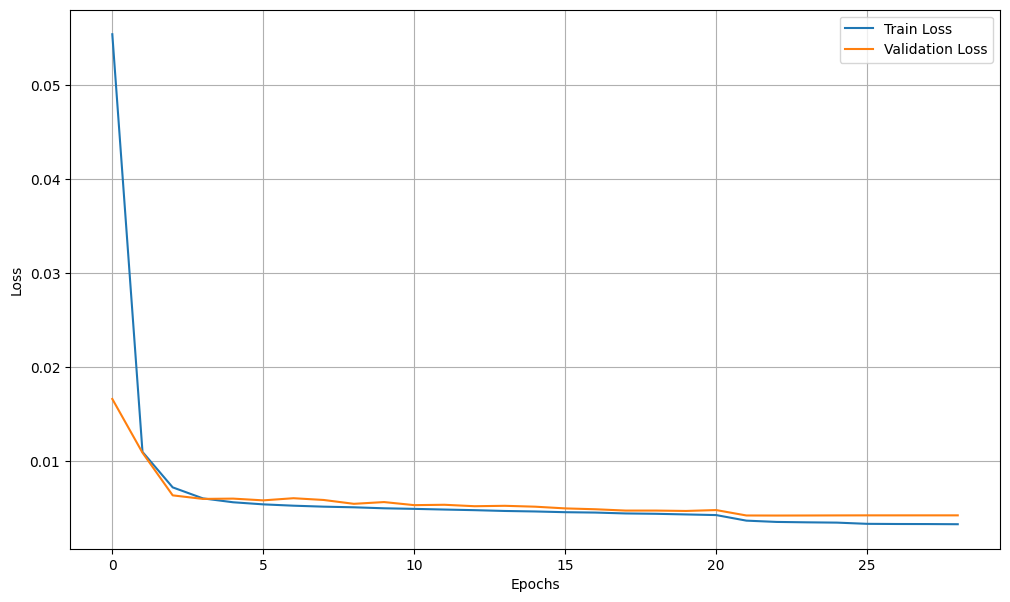

In [47]:
print("=== TRAINING ===")
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
    

In [48]:
mae_scaled = model.evaluate(X_test_seq, y_test_seq, verbose=0)[1]

pred_scaled = model.predict(X_test_seq).flatten()
pred_rescaled = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
test_y_rescaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

print()
print("=== TEST ===")

mae = np.mean(np.abs(pred_rescaled - test_y_rescaled))
print(f'Test MAE on scaled data: {mae_scaled:.3f}')
print(f'Test MAE rescaled to original values: {mae:.3f}')

print()

comp_tab = pd.DataFrame({
    'Data': test_df['date'].iloc[SEQ_LENGTH:SEQ_LENGTH + len(test_y_rescaled)].reset_index(drop=True),
    'Actual': test_y_rescaled,
    'Predicted': pred_rescaled
})
comp_tab = comp_tab.sort_values(by='Data')

print(tabulate(comp_tab, headers='keys', tablefmt='psql'))

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

=== TEST ===
Test MAE on scaled data: 0.056
Test MAE rescaled to original values: 0.566

+------+---------------------------+-------------+-------------+
|      | Data                      |      Actual |   Predicted |
|------+---------------------------+-------------+-------------|
|    0 | 2025-04-23 06:00:00+00:00 | 11.3463     |  11.4682    |
|    1 | 2025-04-23 07:00:00+00:00 | 13.9019     |  14.0062    |
|    2 | 2025-04-23 08:00:00+00:00 | 16.1089     |  15.5906    |
|    3 | 2025-04-23 09:00:00+00:00 | 17.0914     |  17.2338    |
|    4 | 2025-04-23 10:00:00+00:00 | 17.8044     |  18.158     |
|    5 | 2025-04-23 11:00:00+00:00 | 19.033      |  18.6515    |
|    6 | 2025-04-23 12:00:00+00:00 | 20.2122     |  19.5689    |
|    7 | 2025-04-23 13:00:00+00:00 | 20.3525     |  19.3867    |
|    8 | 2025-04-23 14:00:00+00:00 | 20.1171     |  19.5832    |
|    9 | 2025-04-23 15:00:00+00:00 | 19.0434     |  19.0388    |
|   10 | 2025-04-23 16:

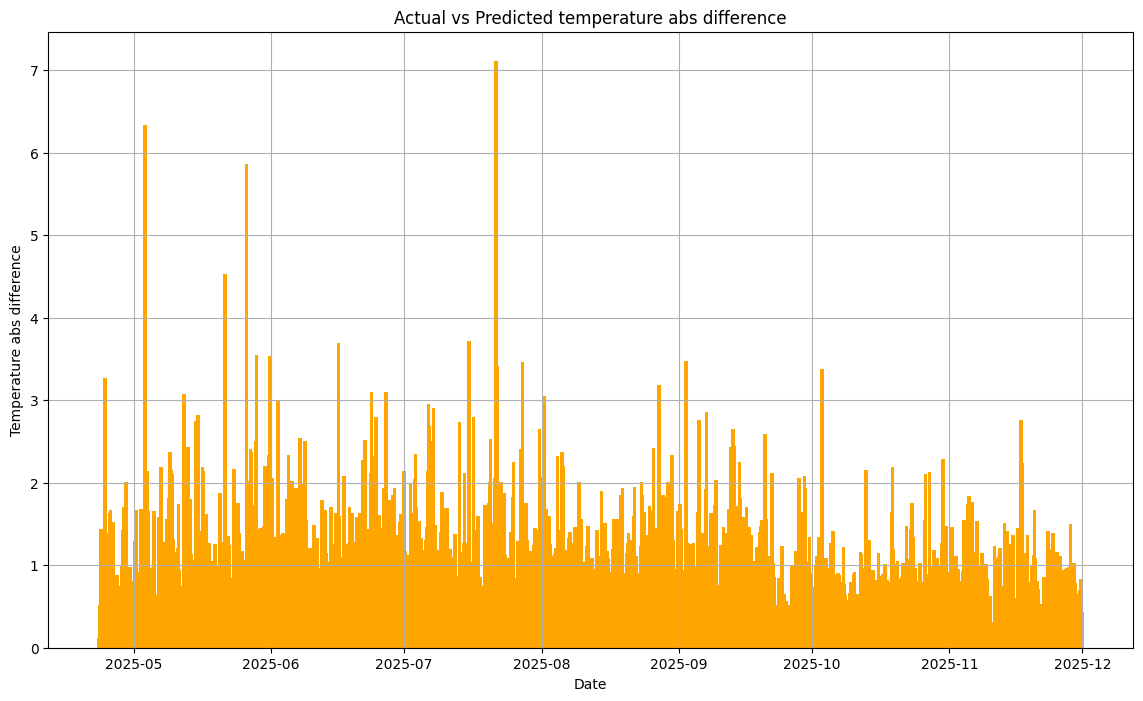

In [49]:
plt.figure(figsize=(14, 8))
diff = np.abs(comp_tab['Actual'] - comp_tab['Predicted'])
plt.bar(comp_tab['Data'], diff, color='orange')
plt.xlabel('Date')
plt.ylabel('Temperature abs difference')
plt.title('Actual vs Predicted temperature abs difference')
plt.grid()
plt.show()

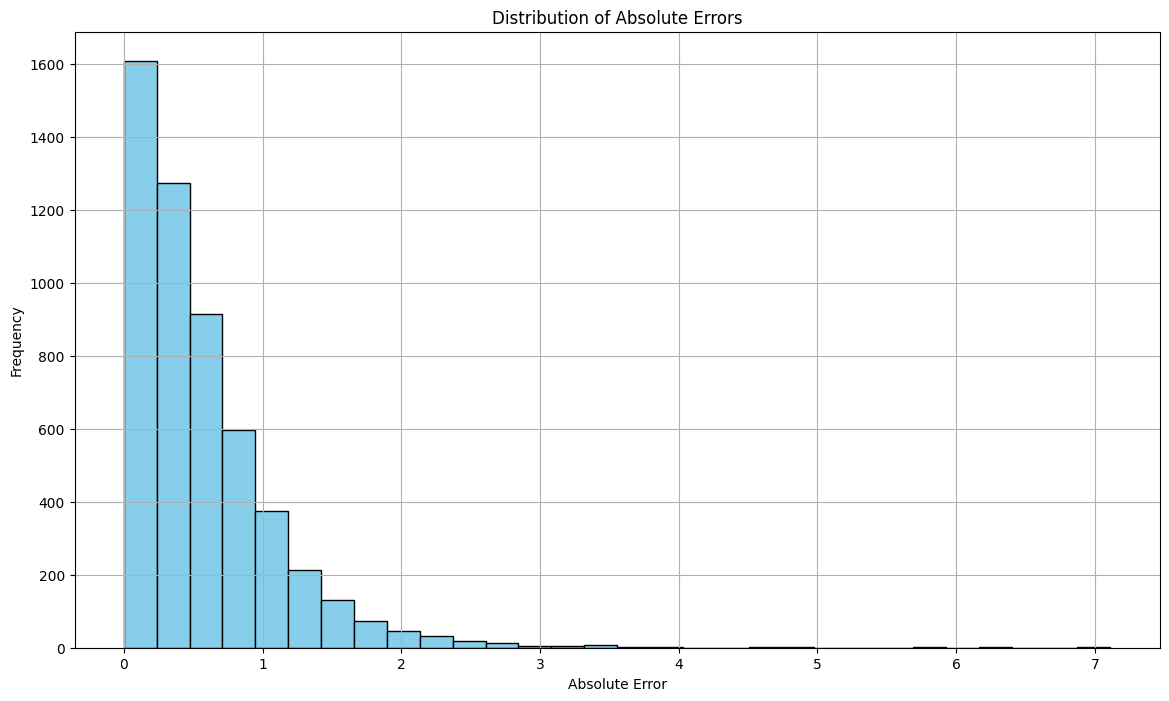

In [50]:
plt.figure(figsize=(14, 8))
plt.hist(diff, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Errors')
plt.grid()
plt.show()